In [ ]:
import pandas as pd 
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
import os
from sklearn.metrics import classification_report,  confusion_matrix, accuracy_score, f1_score

from tensorflow.keras.preprocessing.text import Tokenizer   
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


# Helper Functions

In [ ]:
def import_embeddings(path):
    """
    Loads embeddings from a text file
    """
    import os 
    path_to_glove_file = os.path.join(
      os.path.expanduser("~"), path
    )

    embeddings_index = {}
    with open(path_to_glove_file) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    print("Found %s word vectors." % len(embeddings_index))

    return embeddings_index


### For visualizing trainning loss and validation loss
import matplotlib.pyplot as plt 
def plot_loss(history):
  hist = pd.DataFrame(history.history)
  plt.plot(hist['mae'], label='training_mae')
  plt.plot(hist['val_mae'], label = 'validation_mae')
  plt.legend()
  plt.ylabel("loss")
  plt.xlabel("epochs")
  plt.show()
  

def make_embedding_matrix(word_index, embedding_dim, embeddings_index):
    """
    Returns embedding matrix
    """
    num_tokens = len(word_index) + 2
    hits = 0
    misses = 0

    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))
    return embedding_matrix


def make_model(embedding_matrix, lstm_layer_units, dropout_rate, dense_units, lr=0.001, l2=False):
  """ 
  Returns compiled model with spcified number of hyper paramters
  """

  tf.random.set_seed(42)

  num_tokens, embedding_dim = embedding_matrix.shape

  model = tf.keras.Sequential()
  embedding_layer = Embedding(
      num_tokens,
      embedding_dim,
      embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
      trainable=False)
  
  model.add(embedding_layer)

  for units in lstm_layer_units[:-1]:
    model.add(Bidirectional(LSTM(units, return_sequences=True)))
    model.add(Dropout(dropout_rate))
  

  model.add(Bidirectional(LSTM(lstm_layer_units[-1])))
  model.add(Dropout(dropout_rate))

  if isinstance(dense_units,int) and l2 == False:
    model.add(Dense(dense_units,activation='relu'))
  elif isinstance(dense_units, int) and l2 != False:
     model.add(Dense(dense_units,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(l2=l2)))
  else:
    for units in dense_units:
      if l2 == True:
        model.add(Dense(units,activation='relu'))
      else:
        model.add(Dense(units,activation='relu', kernel_regularizer=tf.keras.regularizers.L2(l2=l2)))
  
  model.add(Dense(1, activation='relu',))

  model.compile(loss='MAE',optimizer=tf.keras.optimizers.Adam(learning_rate=lr) ,metrics=['mae'])

  return model

def compare(X, y_true, y_preds):
  """
  Returns data frame with the test, actual rating, predicited rating, and rounded predicted rating
  """
  return pd.DataFrame({'Text':X, 
                'Actual Rating':y_true, 
                'Predicted Rating':np.squeeze(y_preds),
                'Rounded Rating':np.round(np.squeeze(y_preds))})
  
def get_f1_weighted(compare_df):
  return f1_score(compare_df['Actual Rating'],compare_df['Rounded Rating'], average='weighted')
    



# Loading and Cleaning

In [ ]:
la = pd.read_csv("https://raw.githubusercontent.com/jacobh310/food_nlp/master/data_collection/Los%20Angeles_restaurant.csv")
sd = pd.read_csv("https://raw.githubusercontent.com/jacobh310/food_nlp/master/data_collection/San%20Diego_restaurant.csv")
sf = pd.read_csv("https://raw.githubusercontent.com/jacobh310/food_nlp/master/data_collection/San%20Francisco_restaurant.csv")
oc = pd.read_csv("https://raw.githubusercontent.com/jacobh310/food_nlp/master/data_collection/Orange%20County_restaurant.csv")
at = pd.read_csv('https://raw.githubusercontent.com/jacobh310/food_nlp/master/data_collection/Atalanta_restaurant.csv')
ny = pd.read_csv('https://raw.githubusercontent.com/jacobh310/food_nlp/master/data_collection/New%20York_restaurant.csv')

In [ ]:
def clean_name(col):
    if 'http' in col:
        col = col.split('Reviews')[1]
        col = col.split('-')[-2]
        col = col.replace('_',' ')
        return col
    else:
        return col



In [ ]:
df = pd.concat([la,sd,ny,oc,sf,at])
df['rating'] = df['rating']/10 
df['restaurant'] = df['restaurant'].apply(lambda x: clean_name(x))
df['restaurant'] = df['restaurant'].apply(lambda x: 'In-N-Out Burger' if 'In N Out' in x else x)
df = df[pd.to_numeric(df['review'], errors='coerce').isnull()]
df = df.dropna(subset=['rating','review'])

# Undersample to balance dataset 

In [ ]:
df['rating'].value_counts() 

5.0    585787
4.0    307331
3.0    104800
2.0     36140
1.0     25682
Name: rating, dtype: int64

- Going to make sure every sample has at most 25,682 which is the rating of 1 

In [ ]:
min_value = df['rating'].value_counts().values[-1]
under_df = pd.DataFrame([])
for i in range(1,6):
  under_df = under_df.append(df[df['rating']==i].sample(min_value))


# Splitting Train Test Dev

In [ ]:
def train_dev_test_df(df, splits):
    """"
    Takes in a dataframe and splits into train dev and test
    """
    np.random.seed(42)
    shuffle_df = df.sample(frac=1)

    train, dev = splits

    X = shuffle_df['review'].to_numpy()
    y = shuffle_df['rating'].to_numpy()

    train_cutoff = int(X.shape[0]*train)
    dev_cutoff = int(X.shape[0]*(train+dev))

    X_train = X[:train_cutoff]
    y_train = y[:train_cutoff]

    X_dev = X[train_cutoff:dev_cutoff]
    y_dev = y[train_cutoff:dev_cutoff]

    X_test = X[dev_cutoff:]
    y_test = y[dev_cutoff:]

    y_train = tf.constant(y_train, dtype=tf.int32)
    y_dev = tf.constant(y_dev, dtype = tf.int32)
    y_test = tf.constant(y_test, dtype=tf.int32)

    return X_train, y_train, X_dev, y_dev, X_test, y_test

In [ ]:
X_train, y_train, X_dev, y_dev, X_test, y_test = train_dev_test_df(df,(.9,.05))

In [ ]:
X_utrain, y_utrain, X_udev, y_udev, X_utest, y_utest = train_dev_test_df(under_df,(.8,.10))

# Tokenization

In [ ]:
## redo max length calculation with the avg  plus 1 2 std of training sample only 

vocab_size = 20000
max_length = 110  # 110 is 3 stdevs away from the average number of words in a review 
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

### Regular Sampling Tokenization

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

word_index_token = tokenizer.word_index

X_train_token = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_token, maxlen=max_length, padding=padding_type, truncating=trunc_type)

X_dev_token = tokenizer.texts_to_sequences(X_dev)
X_dev_padded = pad_sequences(X_dev_token, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
X_train_padded = tf.cast(X_train_padded, dtype=tf.float32)
X_dev_padded = tf.cast(X_dev_padded, dtype=tf.float32)

### Make TF dataset

In [ ]:
train_data = (tf.data.Dataset.from_tensor_slices(
    (X_train_padded,
    y_train)
))

dev_data = (tf.data.Dataset.from_tensor_slices(
    (X_dev_padded,
    y_dev)
))

In [ ]:
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=128).prefetch(buffer_size=tf.data.AUTOTUNE)
dev_data = dev_data.batch(128).prefetch(tf.data.AUTOTUNE)

### Under Sampling Tokenization

In [ ]:
utokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
utokenizer.fit_on_texts(X_utrain)

word_index_token = utokenizer.word_index

X_utrain_token = utokenizer.texts_to_sequences(X_utrain)
X_utrain_padded = pad_sequences(X_utrain_token, maxlen=max_length, padding=padding_type, truncating=trunc_type)

X_udev_token = utokenizer.texts_to_sequences(X_udev)
X_udev_padded = pad_sequences(X_udev_token, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
X_utrain_padded = tf.cast(X_utrain_padded, dtype=tf.float32)
X_udev_padded = tf.cast(X_udev_padded, dtype=tf.float32)

# Model Building: No Pretrained Word Embeddings

## WandB Sign in and Configuration

In [ ]:
!pip install wandb

In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
run = wandb.init(project='food-nlp',
                config ={ 
                "epochs": 15,
                "batch_size": 128,
                "loss_function": "MAE",
                "architecture": "LSTM",
                 "Embeddings": 100,
                 "Pretrained Embedding":False,
                 "lstm":[64,32],
                 "dense":10,
                 "dropout":0.5,
                 "learning_rate":0.001
                 })

config = wandb.config

## Model

In [ ]:
model = tf.keras.Sequential([
    Embedding(vocab_size,config.Embeddings , input_length=max_length),
    Bidirectional(LSTM(config.lstm[0], return_sequences=True)),
    Dropout(config.dropout),
    Bidirectional(LSTM(config.lstm[1])),
    Dropout(config.dropout),
    Dense(config.dense,activation='relu'),
    Dense(1,activation='relu')
])

model.compile(loss=config.loss_function,optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate) ,metrics=['mae'])


model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 110, 100)          2000000   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 110, 128)          84480     
_________________________________________________________________
dropout_6 (Dropout)          (None, 110, 128)          0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                650       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

## Training 

In [ ]:
model.fit(train_data,
          epochs=config.epochs,
          steps_per_epoch=len(train_data),
          validation_data=dev_data,
          validation_steps = int(0.15*len(dev_data)),
          callbacks = [WandbCallback()]
          )

In [ ]:

run.join()

epoch,9
loss,0.34911
mae,0.34911
val_loss,0.38176
val_mae,0.38176
_runtime,3206
_timestamp,1625708279
_step,9
best_val_loss,0.37881
best_epoch,5


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▃▂▂▂▂▁▁▁
mae,█▃▃▂▂▂▂▁▁▁
val_loss,█▇▄▂▂▁▃▂▂▂
val_mae,█▇▄▂▂▁▃▂▂▂
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


In [ ]:
loss, mae = model.evaluate(X_dev_padded, y_dev)



1656/1656 [==============================] - 17s 10ms/step - loss: 0.3887 - mae: 0.3887


In [ ]:
y_preds = model.predict(dev_data)
compare_df = compare(X_dev, y_dev, y_preds)
f1 = get_f1_weighted(compare_df)
f1

#Model Building Using Pretrained Glove Embeddingings

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-07-08 17:21:21--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-07-08 17:21:21--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-07-08 17:21:22--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

## Prepare Embedding Matrix

In [ ]:
embeddings_100 = import_embeddings('/content/glove.6B.100d.txt')
embeddings_200 = import_embeddings('/content/glove.6B.200d.txt')
embeddings_300 = import_embeddings('/content/glove.6B.300d.txt')


## makes embedding matrix with token vectors
embedding_matrix_100_token = make_embedding_matrix(word_index_token,100, embeddings_100)
embedding_matrix_200_token = make_embedding_matrix(word_index_token,200, embeddings_200)
embedding_matrix_300_token = make_embedding_matrix(word_index_token,300, embeddings_300)


Found 400000 word vectors.
Found 400000 word vectors.
Found 400000 word vectors.
Converted 59436 words (75591 misses)
Converted 59436 words (75591 misses)
Converted 59436 words (75591 misses)


## WandB Config

In [ ]:
!pip install wandb

In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
run = wandb.init(project='food-nlp',
                config ={ 
                "epochs": 10,
                "batch_size": 128,
                "loss_function": "MAE",
                "architecture": "LSTM",
                 "Embeddings": 300,
                 "Pretrained Embedding":True,
                 "lstm":[64,32],
                 "dense":10,
                 "dropout":0.5,
                 "learning_rate":0.001
                 })

config = wandb.config

## Model

In [ ]:
## using the input made from tokenizer

num_tokens, embedding_dim = embedding_matrix_300_token.shape

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix_300_token),

    trainable=False)
model_embed =  tf.keras.Sequential([
    embedding_layer,
    Bidirectional(LSTM(config.lstm[0], return_sequences=True)),
    Dropout(config.dropout),
    Bidirectional(LSTM(config.lstm[1])),
    Dropout(config.dropout),
    Dense(config.dense,activation='relu'),
    Dense(1,activation='relu')
])

model_embed.compile(loss=config.loss_function,optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate) ,metrics=['mae'])


model_embed.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         13502900  
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 128)         84480     
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
_________________________________________________________________
dense_5 (Dense)              (None, 5)                

## Training

In [ ]:
model_embed.fit(train_data,
          epochs=config.epochs,
          steps_per_epoch=len(train_data),
          validation_data=dev_data,
          validation_steps = int(0.15*len(dev_data)),
          callbacks = [WandbCallback()]
          )

In [ ]:
def wandb_log(dev_data, X_dev, y_dev, model):
  loss, mae = model.evaluate(dev_data)
  y_preds = model.predict(dev_data)
  compare_df = compare(X_dev, y_dev, y_preds)
  f1 = get_f1_weighted(compare_df)
  print(f'MAE: {mae:.2f}')
  print(f'f1: {f1:.2f}')
  wandb.log({'MAE': round(mae,3),
             'F1': round(f1,3)
             })
  
wandb_log(dev_data, X_dev, y_dev, model_embed)

run.join()

epoch,0
loss,nan
accuracy,1e-05
val_loss,nan
val_accuracy,0.0
_runtime,300
_timestamp,1625771390
_step,0


epoch,▁
loss,
accuracy,▁
val_loss,
val_accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


# Finding F1 score

In [ ]:
from sklearn.metrics import classification_report,  confusion_matrix, accuracy_score, f1_score

report = classification_report(compare_df['Actual Rating'],compare_df['Rounded Rating'])
print(report)
get_f1_weighted(compare_df)

              precision    recall  f1-score   support

           1       0.63      0.37      0.47      1336
           2       0.37      0.17      0.23      1746
           3       0.53      0.48      0.50      5323
           4       0.54      0.45      0.49     15329
           5       0.75      0.86      0.80     29253

    accuracy                           0.67     52987
   macro avg       0.56      0.46      0.50     52987
weighted avg       0.65      0.67      0.65     52987



0.6535195929096056

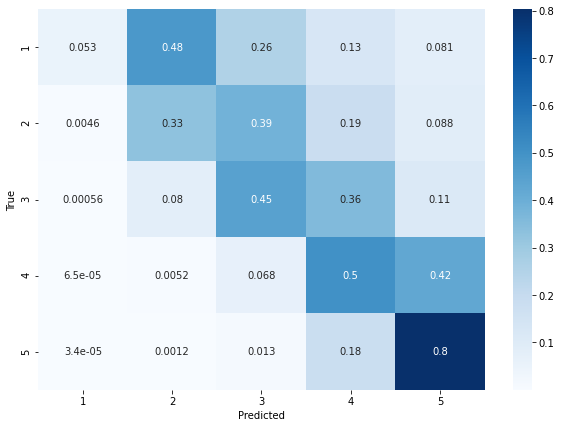

In [ ]:
import seaborn as sn 

cm = confusion_matrix(compare_df['Actual Rating'],compare_df['Rounded Rating'])
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,7))
sn.heatmap(cm_norm,annot=True, cmap=plt.cm.Blues, xticklabels=list(range(1,6)), yticklabels=list(range(1,6)))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification 

## Model

In [ ]:
y_utrain_onehot = tf.one_hot(y_utrain, depth=5)
y_udev_onehot = tf.one_hot(y_udev, depth=5)

In [ ]:
train_data_class = (tf.data.Dataset.from_tensor_slices(
    (X_utrain_padded,
    tf.expand_dims(y_utrain, axis=1))    ### need to expand dims for classifcation
))

dev_data_class = (tf.data.Dataset.from_tensor_slices(
    (X_udev_padded,
    tf.expand_dims(y_udev, axis=1))     ## need to expand dims to for classication
))

In [ ]:
train_data_class = train_data_class.shuffle(buffer_size=1000).batch(batch_size=128).prefetch(buffer_size=tf.data.AUTOTUNE)
dev_data_class = dev_data_class.batch(128).prefetch(tf.data.AUTOTUNE)

In [ ]:
## using the input made from tokenizer

num_tokens, embedding_dim = embedding_matrix_100_token.shape

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix_100_token),

    trainable=False)

model_class =  tf.keras.Sequential([
    embedding_layer,
    Bidirectional(LSTM(64, activation='tanh' return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32, activation='tanh')),
    Dropout(0.5),
    Dense(10,activation='relu'),
    Dense(5,activation='softmax')
])

model_class.compile(loss='categorical_crossentropy',
                    optimizer=tf.keras.optimizers.Adam() ,
                    metrics=['accuracy'])


model_class.summary()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 100)         13502900  
_________________________________________________________________
bidirectional_16 (Bidirectio (None, None, 128)         84480     
_________________________________________________________________
dropout_16 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dropout_17 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                650       
_________________________________________________________________
dense_17 (Dense)             (None, 5)                

In [ ]:
model_class.fit(train_data_class,
          epochs=2,
          steps_per_epoch=len(train_data_class),
          validation_data=dev_data_class,
          validation_steps = int(0.15*len(dev_data_class)))

In [ ]:
under_df['rating']

0